In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from importlib import reload

import warnings
warnings.simplefilter('ignore')

Необязательная фигня (нужна, если надо менять код в импортируемых модулях в процессе работы над ноутбуком).

In [77]:
%load_ext autoreload
%autoreload 2

### 1. Парсер.

Пример использования: нужна 101 форма, сохраняем архивы в заданной директории в папке 101_zipped, сами файлы сохраняются в заданной директории в папке 101. 

**Важные моменты**.
1. Поскольку эти файлы весят несколько гигабайт, я бы не рискнул загружать их в ту же папку, где хранится код для Github. Иначе, когда вы захотите закинуть свой код на гитхаб, вам придется ждать кучу времени, пока данные (больше 10 гб) передадутся.
2. Если какие-то файлы раньше были в папках, которые мы хотим стереть и которые вместе с данными создаем заново, все эти файлы надо закрыть до запуска скрипта! По умолчанию, если в папке, куда мы распаковываем данные, были подпапки с теми же названиями, что и названия папок, которые мы получим при распаковке - старые одноименные папки стираются. 
3. Сами формы 101 и 102 суммарно весят около **10 гб**. С учетом того, что они будут распакованы в два .csv файла, для скачивания и обработки форм нужно иметь не менее **15 гб** свободного места на диске.
4. **Путь**, по которому хранится файл, **должен состоять только из английских букв и слов**. Иначе некоторые Питоновские встроенные программы не работают, поскольку они не работают с кириллицей.

In [2]:
from preprocessing import load_bank_statements, get_bank_names

#### 1.1 Введем путь, по которому мы будем сохранять данные.

In [3]:
path = Path(str(input()))
print(f'Путь, по которому мы будем сохранять архивы и файлы dbf: {path}')

 C:\\Users\\Ivand\\Repos\\banks\\data


Путь, по которому мы будем сохранять архивы и файлы dbf: C:\Users\Ivand\Repos\banks\data


#### 1.2. Загрузим 101 и 102 формы.

In [7]:
%pip install patool

Note: you may need to restart the kernel to use updated packages.


In [5]:
%%time
load_bank_statements(form_number=101, filepath=path)

100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:05<00:00, 36.36it/s]


PatoolError: patool can not unpack
patool error: error extracting C:\Users\Ivand\Repos\banks\data\101_zipped\20181101: unknown archive format for file `C:\Users\Ivand\Repos\banks\data\101_zipped\20181101'

In [6]:
load_bank_statements(form_number=102, filepath=path)

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 550.04it/s]


PatoolError: patool can not unpack
patool error: error extracting C:\Users\Ivand\Repos\banks\data\102_zipped\20170401: unknown archive format for file `C:\Users\Ivand\Repos\banks\data\102_zipped\20170401'

#### 1.3. Считаем и объединим все файлы с именами.

Сделаем это для 101 и 102 формы, результат сравним. По идее, REGN - уникальные числовые индикаторы для названий банков - должны совпадать для всех форм (101, 102 и так далее) - еще один вопрос к Помориной.

Я записал путь для чтения названий банков из папки ``path/'101'``, так как такую запись позволяет библиотека Pathlib. Она есть в Питоне по умолчанию и очень удобна для работы с путями до файлов или папок.

In [7]:
import preprocessing
import functools

In [8]:
out = get_bank_names(filepath=path/'101', form_number=101)

In [9]:
out.head(5)

,REGN,NAME_B
0,1,ЗАО ЮНИКРЕДИТ БАНК
1,3,"МАКБ ""ПРЕМЬЕР"" ЗАО"
2,21,"ООО ""ПРИМТЕРКОМБАНК"""
3,52,"ОАО ""ЭНЕРГОМАШБАНК"""
4,55,"ОАО МАБ ""ТЕМПБАНК"""


In [10]:
out102 = get_bank_names(filepath=path/'102', form_number=102)

In [9]:
out102.head(5)

,REGN,NAME_B
0,1,ЗАО ЮНИКРЕДИТ БАНК
1,3,"МАКБ ""ПРЕМЬЕР"" ЗАО"
2,21,"ООО ""ПРИМТЕРКОМБАНК"""
3,52,"ОАО ""ЭНЕРГОМАШБАНК"""
4,55,"ОАО МАБ ""ТЕМПБАНК"""


In [31]:
out.shape, out102.shape

((1143, 2), (1137, 2))

Не все банки, которые есть в форме 101, попали в форму 102. Возможно и обратное: если в 102 форме меньше банков, это не значит, что в ней нет названий, не попавших в форму 101. Посмотрим на банки, которые попали только в одну из двух форм:

In [11]:
mismatch = pd.concat([out, out102]).drop_duplicates(subset='REGN', keep=False)
mismatch
print(f'Количество банков, не попавших в обе формы: {mismatch.shape[0]}')

Количество банков, не попавших в обе формы: 39


Теперь уже за исследователем решение, что делать. Но поскольку этих банков не очень много, и они не слишком похожи на системно значимые, для модели дефолта оптимальная стратегия будет просто выкинуть их из выборки.

**Важно!** Также, чтобы не было путаницы с названиями, в дальнейшей работе надо будет использовать для работы и с формой 101, и с формой 102 один и тот же датафрейм с названиями банков - вполне возможно, название какого-то банка из формы 101 забито большими буквами в стобце `NAME_B` формы 102, может возникнуть ненужная путаница.

**Заметки по поводу агрегируемых файлов.**
1. Для сбора имен я считывал все файлы из 101 формы, в названии которых есть `N1`, для формы 102 ищутся файлы с `NP1` в названии. Но также для 2004-2008 в форме 101 есть файлы с `N`, в которых тоже содержатся имена банков - видимо, это для древнего формата отчетности. Аналогично, для формы 102 такие файлы содержат в названии `NP`. Вопрос: стоит ли учитывать более древние файлы? В связи с чем долгое время публиковались оба формата одновременно? Марина Александровна сказала разобраться с этим самостоятельно. Поскольку `N`, `NP1` в последние годы не публикуются, я решил использовать более современные файлы.
2. Аналогичный вопрос по самим отчетам - долгое время публиковалось сразу по 6 файлов за 1 месяц или квартал, то есть старый и новый форматы отчетности. В связи с чем это делалось? Стоит ли это учитывать, если да, то как? Я решил использовать более современные файлы с `B1` и `_P1` в названиях, которые публикуются с 2007 года по настоящее время.

#### 1.4. Считаем и объединим файлы с отчетностью.
Осталось считать сами файлы с отчетностью. Особенности считывания:
1. При считывании даты делаются индексом в табличке.
2. Есть ряд странных счетов в форме 101, расшифровку которых в документах ЦБ я найти не смог. Эти счета: ITGAP', '304.1', '408.1', '408.2', '474.1', '1XXXX', '2XXXX', '3XXXX', '4XXXX', '5XXXX', '6XXXX','7XXXX', '8XXXX', '9XXXX'. По умолчанию функция ``read_form`` удаляет эти счета. Это делается, чтобы столбец с номером счета можно было преобразовать в формат `integer`. Такое преобразование позволяет существенно оптимизировать скорость обработки файла и объем памяти, требуемой для хранения файла. За удаление ненужных параметров отвечает опция ``remove_unknown_accs.``
3. Опция ``to_int`` позволяет конвертировать столбец с номерами счетов в целочисленный формат.
4. До 2015 года в 102 форме не ставили столбец с датой. Это учтено, создается дата по названию папки.

In [12]:
from preprocessing import read_form

In [13]:
%%time
test = read_form(path/'101', form_number=101)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]

Reading .dbf files from your PC, please wait...


Opened files. Merging them...
Done.
Wall time: 45 s


In [14]:
test

,REGN,PLAN,NUM_SC,A_P,VR,VV,VITG,ORA,OVA,OITGA,ORP,OVP,OITGP,IR,IV,IITG,PRIZ
DT,,,,,,,,,,,,,,,,,
2007-01-01,1,А,10206,2,4540424.0,0.0,4540424.0,720888.0,0.0,720888.0,3107579.0,0.0,3107579.0,6927115,0,6927115.0,1
2007-01-01,2721,А,47411,2,6339.0,5913.0,12252.0,2935.0,726.0,3661.0,2329.0,2328.0,4657.0,5733,7515,13248.0,1
2007-01-01,2721,А,47408,1,0.0,0.0,0.0,11788.0,51990.0,63778.0,11788.0,51990.0,63778.0,0,0,0.0,1
2007-01-01,2721,А,47407,2,0.0,0.0,0.0,45580.0,18218.0,63798.0,45580.0,18218.0,63798.0,0,0,0.0,1
2007-01-01,2721,А,47405,2,0.0,0.0,0.0,0.0,4859.0,4859.0,0.0,4859.0,4859.0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-01,1398,А,61002,1,230.0,0.0,230.0,78.0,0.0,78.0,21.0,0.0,21.0,287,0,287.0,1
2008-12-01,1398,А,60701,1,12075.0,0.0,12075.0,328.0,0.0,328.0,264.0,0.0,264.0,12139,0,12139.0,1
2008-12-01,1398,А,60601,2,41903.0,0.0,41903.0,18.0,0.0,18.0,1328.0,0.0,1328.0,43213,0,43213.0,1


Посмотрим на столбцы и типы данных в объединенной 101 форме.

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22335039 entries, 2007-01-01 to 2021-09-01
Data columns (total 17 columns):
 #   Column  Dtype  
---  ------  -----  
 0   REGN    int64  
 1   PLAN    object 
 2   NUM_SC  int32  
 3   A_P     object 
 4   VR      float64
 5   VV      float64
 6   VITG    float64
 7   ORA     float64
 8   OVA     float64
 9   OITGA   float64
 10  ORP     float64
 11  OVP     float64
 12  OITGP   float64
 13  IR      float64
 14  IV      float64
 15  IITG    float64
 16  PRIZ    int64  
dtypes: float64(12), int32(1), int64(2), object(2)
memory usage: 2.9+ GB


Теперь 102 форма.

In [15]:
%%time
test102 = read_form(path/'102', 102)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]

Reading .dbf files from your PC, please wait...


Opened files. Merging them...
Done.
Wall time: 4.35 s


In [16]:
test102

,REGN,CODE,SIM_R,SIM_V,SIM_ITOGO
DT,,,,,
2007-01-01,1,10000,81264287.0,10621859.0,91886146
2007-01-01,1,11000,4472576.0,7182692.0,11655268
2007-01-01,1,11101,0.0,0.0,0
2007-01-01,1,11102,11884.0,0.0,11884
2007-01-01,1,11103,0.0,0.0,0
...,...,...,...,...,...
2008-04-01,3467,32003,NaN,NaN,0
2008-04-01,3467,32004,NaN,NaN,0
2008-04-01,3467,32005,NaN,NaN,0


In [17]:
test102.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1042581 entries, 2007-01-01 to 2008-04-01
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   REGN       1042581 non-null  int64  
 1   CODE       1042581 non-null  int32  
 2   SIM_R      1036143 non-null  float64
 3   SIM_V      980311 non-null   float64
 4   SIM_ITOGO  1042581 non-null  int64  
dtypes: float64(2), int32(1), int64(2)
memory usage: 43.7 MB


#### 1.5 Сохраним объединенные таблицы с отчетностью.
Сохраним оба файла в папку с данными. Сохранять в ``csv`` бесполезно - это займет кучу времени. Надо сохранять в формате ``HDF``, он работает гораздо быстрее.

In [18]:
%%time
test.to_hdf(path/'101.h5', key='101', mode='w')
test102.to_hdf(path/'102.h5', key='102', mode='w')

Wall time: 7.48 s


### 2. Группировка.
Теперь попробуем работать с группировкой. 
Для группировки посчитаем 
- розничные кредиты физическим лицам, включая просроченные, 
- и кредиты юридическим лица на балансе банков по [методике КУАП](https://kuap.ru/methodics/). 

При проверке будем учитывать, что 101 форма в тысячах рублей (**Проверить что со 102 насчет размерности**).

Загрузим функцию ``group``, которая отвечает за группировку. Есть два варианта, как передать ей схему для группировки: в виде словаря или в виде датафрейма.

Предлагаю, чтобы не портить код вставками гигантских словарей для группировки по счетам, сохранять
- словари для группировки в файле parameters.py, как это сделал я со словарем для примера - ``example_dict``
- или же, если информация для группировки счетов хранится в виде датафреймов, сохранять эти датафреймы в excel или csv в папке ``data``

**Вариант 1. Словарь для группировки**.

In [19]:
form101 = pd.read_hdf(path/'101.h5',key='101')

In [78]:
from preprocessing import group
from parameters import example_dict

In [21]:
print(f"""
Первая пара "новый счет: список старых счетов" для группировочного словаря:
{list(example_dict.keys())[0]}:{list(example_dict.values())[0][0:3]}...
Вторая пара "новый счет: список старых счетов" для группировочного словаря:
{list(example_dict.keys())[1]}:{list(example_dict.values())[1][0:3]}...
""")


Первая пара "новый счет: список старых счетов" для группировочного словаря:
Кредиты физическим лицам:[45502, 45508, 45509]...
Вторая пара "новый счет: список старых счетов" для группировочного словаря:
Кредиты юридическим лицам:[45101, 45103, 45109]...



In [51]:
example_dict["SomethingElse"] = []

In [52]:
%%time
credits = group(data=form101, aggschema=example_dict, form=101)

Grouping and aggregating data. Please be patient...
Finished.
Wall time: 1.93 s


In [54]:
credits.head()

,REGN,new_code,IITG
DT,,,
2007-01-01,1,Кредиты физическим лицам,22332830.0
2007-01-01,1,Кредиты юридическим лицам,125305798.0
2007-02-01,1,Кредиты физическим лицам,23046669.0
2007-02-01,1,Кредиты юридическим лицам,126756486.0
2007-03-01,1,Кредиты физическим лицам,23806028.0


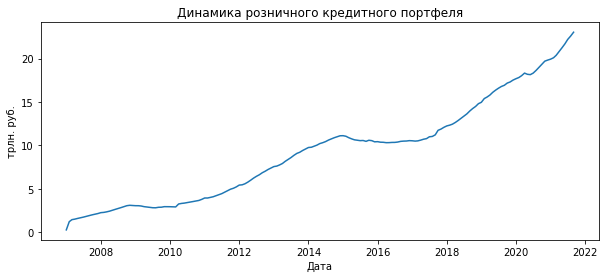

In [23]:
fiz = credits.groupby([credits.index, credits.new_code]).agg({'IITG':'sum'}).reset_index()
fiz = fiz[['DT', 'new_code', 'IITG']]
fiz.IITG = fiz.IITG/(10**9)
fiz = fiz[fiz['new_code']=='Кредиты физическим лицам']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(fiz.DT, fiz.IITG)
ax.set_title('Динамика розничного кредитного портфеля')
ax.set_xlabel('Дата')
ax.set_ylabel('трлн. руб.')
fig.show();

Что ж, здесь вполне четко видно три кредитных цикла в розничном кредитовании России. Заметим, что первое наблюдение явно похоже на выброс - в январе 2007 года банки только начали публиковать отчетность в новом формате, возможно, стоит просто выкинуть этот месяц из выборки.

Сравним с тем, что показывает ЦБ в агрегированной статистике банковского сектора за август. ЦБ показало кредиты физлицам на 23.08 трлн руб в августе, на 22.67 трлн. руб. в июле. А у нас?

In [24]:
fiz.iloc[-3:]

,DT,new_code,IITG
348,2021-07-01,Кредиты физическим лицам,22.196474
350,2021-08-01,Кредиты физическим лицам,22.583117
352,2021-09-01,Кредиты физическим лицам,23.025961


Наши расчеты стабильно меньше на 2.2%.

**Вариант 2. Датафрейм для группировки.**

Сделаем из нашего датафрейма словарь и пихнем его в функцию.

In [26]:
newdict = {y:x[0] for x in example_dict.items() for y in x[1]}
aggdf = pd.DataFrame({'new_code': list(newdict.values()),
                      'NUM_SC': list(newdict.keys())})
aggdf.head()

,new_code,NUM_SC
0,Кредиты физическим лицам,45502
1,Кредиты физическим лицам,45508
2,Кредиты физическим лицам,45509
3,Кредиты физическим лицам,45701
4,Кредиты физическим лицам,45707


In [27]:
%%time
credits_2 = group(data=form101, aggschema=aggdf, form=101)

Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 9.06 s, sys: 2.64 s, total: 11.7 s
Wall time: 11.7 s


Проверим, что результаты совпадают.

In [52]:
from pandas._testing import assert_frame_equal
assert_frame_equal(credits, credits_2)

Все совпало. Это победа!

#### Получаем словари для группировки 

Импортируем функцию для группировки

In [27]:
from preprocessing import create_all_dictionaries_for_one_sheet

Укажем путь к файлу с деревьями

In [28]:
path = str(input())
print(f'Путь, по которому лежит файл Деревья.xlsx: {path}.')

 C:\\Users\\Ivand\\Repos\\banks\\data


Путь, по которому лежит файл Деревья.xlsx: C:\\Users\\Ivand\\Repos\\banks\\data.


Выгрузим листы с группировками из этого файла

In [29]:
trees = [pd.read_excel(path + "\Деревья.xlsx", sheet_name = sheet_index) for sheet_index in [0,1,3,4,5]]
trees_forms = ["BS", "BS", "PNL", "PNL", "PNL"]

Получим список словарей для пятого уровня группировки PNL и второго BS (занимает меньше минуты)

In [30]:
all_dictionaries = [create_all_dictionaries_for_one_sheet(tree, 5, 2, form) for tree, form in zip(trees, trees_forms)]

In [31]:
all_dictionaries_dict = dict(zip(["BS_old", "BS_new", "PNL_very_old", "PNL_old", "PNL"], all_dictionaries))

In [32]:
from pprint import pprint

In [33]:
import json
with open('parameters.json', 'w') as fp:
    json.dump(all_dictionaries_dict, fp)

#load it

with open('parameters.json') as f:
    all_dictionaries_dict = json.load(f)


In [34]:
#вроде работает технически, но в файле есть какие-то значения, которых явно нет в жизни, 
#через тире и прочее
#многобуков алёрт
pprint(all_dictionaries_dict["PNL"])

[{'Чистый процент.доход/(убыток) до формирования/(возмещ) РВПС': {'A': ['72104_0010',
                                                                        '72105_0010',
                                                                        '72303_0010',
                                                                        '72304_0010',
                                                                        '72703_0010',
                                                                        '72704_0010',
                                                                        '72104_0020',
                                                                        '72105_0020',
                                                                        '72106_0020',
                                                                        '72303_0020',
                                                                        '72304_0020',
                                                      

In [224]:
test102

,REGN,CODE,SIM_R,SIM_V,SIM_ITOGO
DT,,,,,
2007-01-01,1,10000,81264287.0,10621859.0,91886146
2007-01-01,1,11000,4472576.0,7182692.0,11655268
2007-01-01,1,11101,0.0,0.0,0
2007-01-01,1,11102,11884.0,0.0,11884
2007-01-01,1,11103,0.0,0.0,0
...,...,...,...,...,...
2008-04-01,3467,32003,NaN,NaN,0
2008-04-01,3467,32004,NaN,NaN,0
2008-04-01,3467,32005,NaN,NaN,0


#### Группировка
Проделаем группировку. Сначала по шагам:

In [75]:
test.NUM_SC = test.NUM_SC.apply(str)

In [136]:
reload(preprocessing)

<module 'preprocessing' from 'C:\\Users\\Ivand\\Repos\\banks\\code\\preprocessing.py'>

In [153]:
#получим позитивный и негативный словари для BS_old
BS_old_grouping_dictionary_positive, BS_old_grouping_dictionary_negative = \
                                    preprocessing.positive_negative_dictionaries(all_dictionaries_dict, "BS_old")



In [180]:
#делаем группировку для старого формата 101 формы
test_BS_old = preprocessing.subset_df_to_dates(test, "BS_old")
BS_old_positive_grouping = group(data=test_BS_old, aggschema=BS_old_grouping_dictionary_positive, form=101)
BS_old_negative_grouping = group(data=test_BS_old, aggschema=BS_old_grouping_dictionary_negative, form=101)

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


Теперь объединим позитивные и негативные таблицы, заполним пропуски (там, где коды оказались только одного знака) нулями и просуммируем

In [184]:
BS_old_grouping = BS_old_positive_grouping.merge(BS_old_negative_grouping, on = ["REGN", "new_code", "DT"], how = "outer",
                                                 suffixes = ("_positive", "_negative"))

In [185]:
BS_old_grouping

,REGN,new_code,IITG_positive,IITG_negative
DT,,,,
2007-01-01,1,Денежные средства (касса и остатки на кор.счет...,16692537.0,NaN
2007-01-01,1,Инвестиции,522840.0,1846.0
2007-01-01,1,Нераспределенная прибыль,1986575.0,14841016.0
2007-01-01,1,Обязательные резервы в ЦБ РФ,3934565.0,NaN
2007-01-01,1,"Основные средства, за вычетом накопленной амор...",5314010.0,1865464.0
...,...,...,...,...
2008-12-01,3470,Обязательства по налогу на прибыль,NaN,0.0
2008-12-01,3470,Прочие пассивы,NaN,452.0
2008-12-01,3470,Средства банков,NaN,2135256.0


In [186]:
BS_old_grouping = BS_old_grouping.fillna(0)

In [187]:
BS_old_grouping

,REGN,new_code,IITG_positive,IITG_negative
DT,,,,
2007-01-01,1,Денежные средства (касса и остатки на кор.счет...,16692537.0,0.0
2007-01-01,1,Инвестиции,522840.0,1846.0
2007-01-01,1,Нераспределенная прибыль,1986575.0,14841016.0
2007-01-01,1,Обязательные резервы в ЦБ РФ,3934565.0,0.0
2007-01-01,1,"Основные средства, за вычетом накопленной амор...",5314010.0,1865464.0
...,...,...,...,...
2008-12-01,3470,Обязательства по налогу на прибыль,0.0,0.0
2008-12-01,3470,Прочие пассивы,0.0,452.0
2008-12-01,3470,Средства банков,0.0,2135256.0


In [188]:
BS_old_grouping["IITG"] = BS_old_grouping.IITG_positive - BS_old_grouping.IITG_negative

In [189]:
BS_old_grouping

,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2007-01-01,1,Денежные средства (касса и остатки на кор.счет...,16692537.0,0.0,16692537.0
2007-01-01,1,Инвестиции,522840.0,1846.0,520994.0
2007-01-01,1,Нераспределенная прибыль,1986575.0,14841016.0,-12854441.0
2007-01-01,1,Обязательные резервы в ЦБ РФ,3934565.0,0.0,3934565.0
2007-01-01,1,"Основные средства, за вычетом накопленной амор...",5314010.0,1865464.0,3448546.0
...,...,...,...,...,...
2008-12-01,3470,Обязательства по налогу на прибыль,0.0,0.0,0.0
2008-12-01,3470,Прочие пассивы,0.0,452.0,-452.0
2008-12-01,3470,Средства банков,0.0,2135256.0,-2135256.0


In [223]:
grouped_BS_old = preprocessing.group_one_form(test, "BS_old", all_dictionaries_dict)
grouped_BS_old

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2007-01-01,1,Денежные средства (касса и остатки на кор.счет...,16692537.0,0.0,16692537.0
2007-01-01,1,Инвестиции,522840.0,1846.0,520994.0
2007-01-01,1,Нераспределенная прибыль,1986575.0,14841016.0,-12854441.0
2007-01-01,1,Обязательные резервы в ЦБ РФ,3934565.0,0.0,3934565.0
2007-01-01,1,"Основные средства, за вычетом накопленной амор...",5314010.0,1865464.0,3448546.0
...,...,...,...,...,...
2008-12-01,3470,Обязательства по налогу на прибыль,0.0,0.0,0.0
2008-12-01,3470,Прочие пассивы,0.0,452.0,-452.0
2008-12-01,3470,Средства банков,0.0,2135256.0,-2135256.0


In [222]:
grouped_PNL = preprocessing.group_one_form(test102, "PNL_very_old", all_dictionaries_dict)
grouped_PNL

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2007-01-01,1,Возмещение /(формирование) резервов на потери ...,12062371.0,22313050.0,-10250679.0
2007-01-01,1,Затраты на ведение деятельности до формировани...,3994210.0,70091.0,3924119.0
2007-01-01,1,Прочие операционные доходы/расходы,137050.0,143326.0,-6276.0
2007-01-01,1,"Резервы по прочим операциям, кроме резервов по...",0.0,0.0,0.0
2007-01-01,1,Чистые комиссионные доходы,148281.0,2517689.0,-2369408.0
...,...,...,...,...,...
2007-07-01,3467,Чистый доход по операциям сдечи имущества в ар...,0.0,150.0,-150.0
2007-07-01,3467,Чистый процент.доход/(убыток) до формирования/...,0.0,3715.0,-3715.0
2007-10-01,3467,Чистые доходы от инвестиций,0.0,0.0,0.0
